In [1]:
from datetime import datetime
from datetime import datetime
from io import StringIO
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import requests
import scipy as sp
import statsmodels.api as sm
from openpyxl import Workbook
from openpyxl import load_workbook
from pandas_datareader import data, wb
from scipy import stats
from scipy.stats import mode
from scipy.stats.mstats import normaltest
from sklearn import linear_model
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

from cs109.dataloader import build_dataset

%matplotlib inline

/Users/melissacurran/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#  Data Collection

All the data has been collected from open and free sources.

### Microsoft Stock 

We get Microsoft adjusted closing price from Yahoo Finance. The data is available for every trading day since 1995. In our dataset it is represented by a variable 'Adj Close'. 

### S&P500

We get S&P500 closing price from http://www.cboe.com/micro/buywrite/dailypricehistory.xls. The data is available for every trading day since 1986 (data from Yahoo Finance only available from 2005). In our dataset it is represented by a variable 'SP500'.

###  10-Year Treasury Constant Maturity Rate

The data can be downloaded from https://fred.stlouisfed.org/series/DGS10 in CSV format. The data is available for every trading day since 1989. In our dataset it is represented by a variable 'DGS10'.

###  Federal Funds Rate

The data can be downloaded from https://fred.stlouisfed.org/series/FEDFUNDS in CSV format. The data is available for every calendar month since 1954. We adjust the data frequency to trading day by padding it forward. In our dataset it is represented by a variable 'FEDFUNDS'.

### Microsoft Earnings

The data can be downloaded from https://www.microsoft.com/en-us/Investor/earnings/trended/quarterly-income-statements.aspx in Microsoft Excel format. The data is available quarterly starting from Q3 1995. We get Revenue, Gross Margin, Operating Income and Diluted EPS.  We adjust the data frequency to trading day by padding it forward.

### Acquisition History

The data is available from https://www.microsoft.com/en-us/Investor/acquisition-history.aspx and consists of the press release date and the company name. It was manually copied and converted into CSV format. In our dataset it is represented by 'Acquisition' variable with a value of one if a press release happened on the date and zero otherwise.

### Investment History

The data is available from https://www.microsoft.com/en-us/Investor/investment-history.aspx and consists of the press release date and the company name. It was manually copied and converted into CSV format. In our dataset it is represented by 'Investment' variable with a value of one if a press release happened on the date and zero otherwise.

### SEC Filings

The SEC filings data is available from https://www.microsoft.com/en-us/Investor/sec-filings.aspx. It was manually copied and converted into the CSV format. It is available from 1994 and consist of the filing date and the document type. In our dataset it is represented by a set of dummy variables. The variable name is the document type and the value is one if the document type was filed on the date, zero otherwise.

### Data Refresh

Only the adjusted closed price is automatically refreshed and includes the newest data. All other sources have to be manually updated by downloading relevant files from the sources.

### Load the Dataset 

In [2]:
msft_data = build_dataset()

In [3]:
msft_data.head(n = 10)

,Adj Close,Diluted EPS,Gross Margin,Operating Income,Revenue,SP500,FEDFUNDS,DGS10,Acquisition,Investment,...,SC 13D,SC 13D/A,SC 13G,SC 13G/A,SC TO-C,SC TO-I,SC TO-I/A,SC TO-T,SC TO-T/A,SD
1995-03-31,3.018377,0.04,1272.0,544.0,1627.0,500.71,5.98,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-03,2.970635,0.04,1272.0,544.0,1627.0,501.85,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-04,2.965330,0.04,1272.0,544.0,1627.0,505.24,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-05,2.997158,0.04,1272.0,544.0,1627.0,505.57,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-06,2.970635,0.04,1272.0,544.0,1627.0,506.08,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-07,2.954721,0.04,1272.0,544.0,1627.0,506.42,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-10,3.010420,0.04,1272.0,544.0,1627.0,507.01,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-11,3.060815,0.04,1272.0,544.0,1627.0,505.53,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-12,3.039596,0.04,1272.0,544.0,1627.0,507.17,6.05,6.22,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-04-13,3.076729,0.04,1272.0,544.0,1627.0,509.23,6.05,6.22,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#  Data Exploration

In [4]:
def show_hist_box(df, column, figsize=(10, 5)):
    fig = plt.figure(figsize=figsize)
    h = df.hist(column, bins = 50, ax = fig.add_subplot(1, 2, 1))
    p = df.boxplot(column, ax = fig.add_subplot(1, 2, 2), return_type = 'dict')
    return None

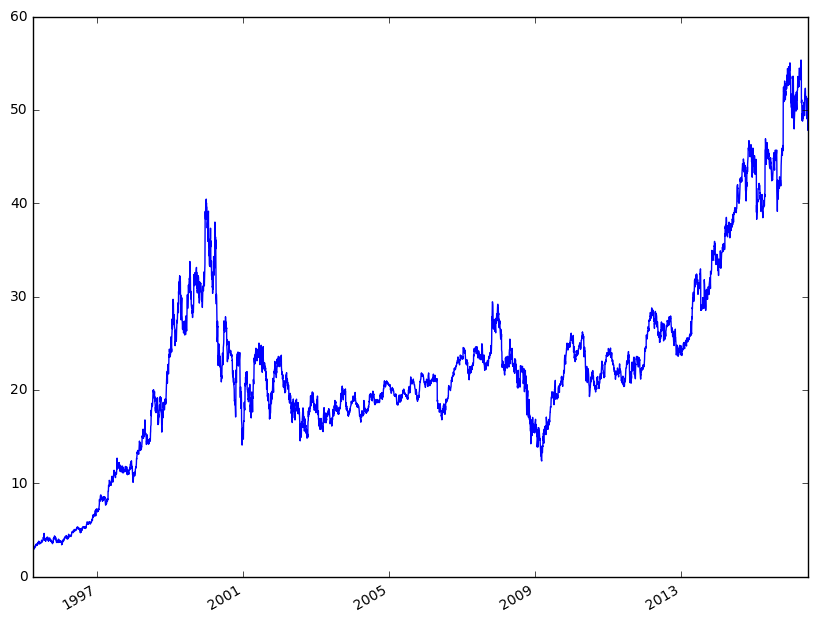

In [5]:
msft_data['Adj Close'].plot(figsize=(10, 8))

### Statistical Anomaly Detection

If we could prove that the closing price (or any transformation of the closing price) is normally distributed, we could use the Z-score to detect outliers with a defined confidence interval.  

p-value (H0: close price is normally distributed) 1.37094788325e-153


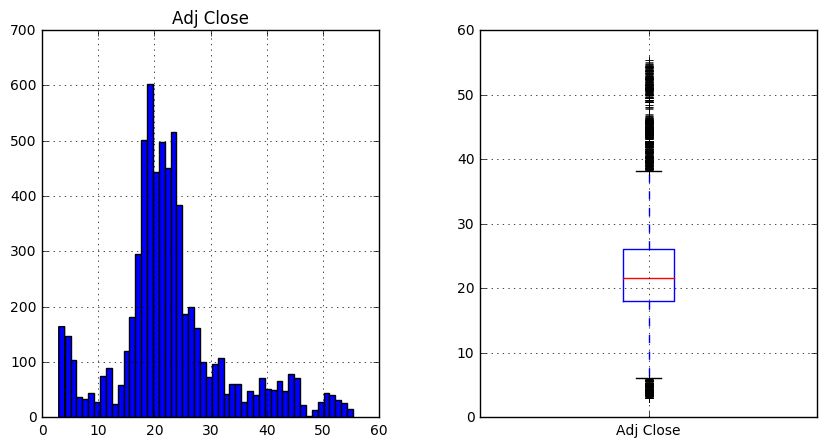

In [6]:
show_hist_box(msft_data, 'Adj Close')
print 'p-value (H0: close price is normally distributed)', normaltest(msft_data['Adj Close']).pvalue

In [7]:
msft_data['First Difference'] = msft_data['Adj Close'] - msft_data['Adj Close'].shift()
msft_data['First Difference'] = msft_data['First Difference'].fillna(0.0)

p-value (H0: first difference is normally distributed) 0.0


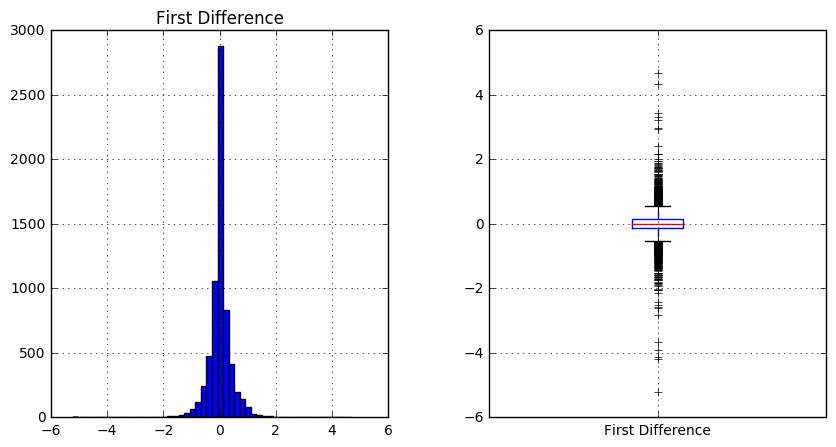

In [8]:
show_hist_box(msft_data, 'First Difference')
print 'p-value (H0: first difference is normally distributed)', normaltest(msft_data['First Difference']).pvalue

In [9]:
msft_data['Second Difference'] = msft_data['First Difference'] - msft_data['First Difference'].shift()
msft_data['Second Difference'] = msft_data['Second Difference'].fillna(0.0)

p-value (H0: second difference is normally distributed) 2.32278169991e-252


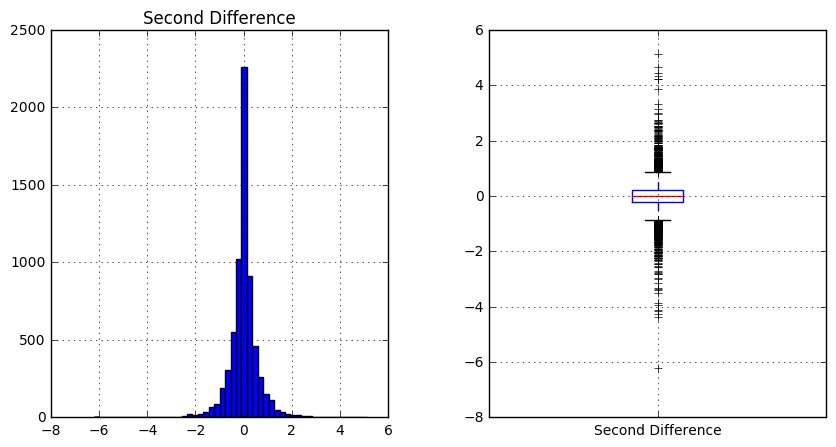

In [10]:
show_hist_box(msft_data, 'Second Difference')
print 'p-value (H0: second difference is normally distributed)', normaltest(msft_data['Second Difference']).pvalue

In [11]:
msft_data['Moving Average 7'] = msft_data['Adj Close'].rolling(window=7).mean().fillna(0.0)
msft_data['MA7 Difference'] = msft_data['Adj Close'] - msft_data['Moving Average 7']
msft_data['MA7 Difference'] = msft_data['MA7 Difference'].fillna(0.0)

p-value (H0: MA7 difference is normally distributed) 4.52383800122e-259


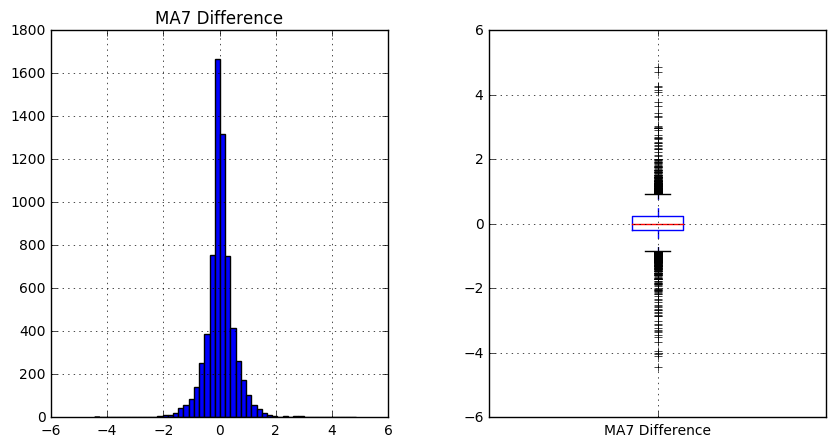

In [12]:
show_hist_box(msft_data, 'MA7 Difference')
print 'p-value (H0: MA7 difference is normally distributed)', normaltest(msft_data['MA7 Difference']).pvalue

In [13]:
msft_data['Moving Average 30'] = msft_data['Adj Close'].rolling(window=30).mean().fillna(0.0)
msft_data['MA30 Difference'] = msft_data['Adj Close'] - msft_data['Moving Average 30']
msft_data['MA30 Difference'] = msft_data['MA30 Difference'].fillna(0.0)

p-value (H0: MA30 difference is normally distributed) 4.30778873739e-167


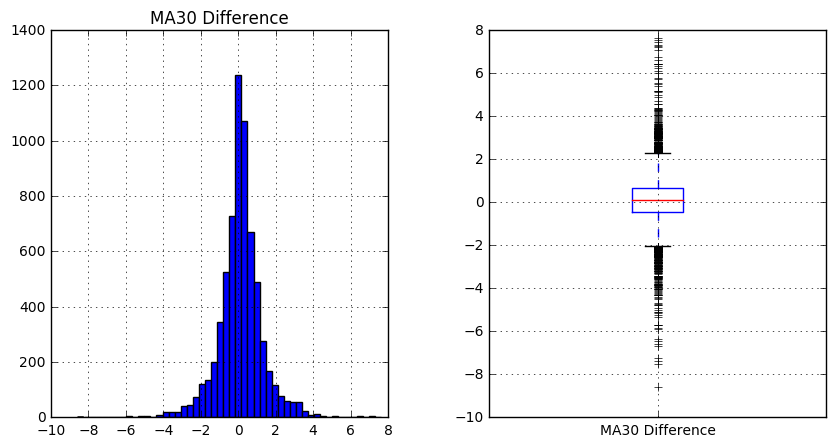

In [14]:
show_hist_box(msft_data, 'MA30 Difference')
print 'p-value (H0: MA30 difference is normally distributed)', normaltest(msft_data['MA30 Difference']).pvalue

In [15]:
msft_data['Moving Average 120'] = msft_data['Adj Close'].rolling(window=120).mean().fillna(0.0)
msft_data['MA120 Difference'] = msft_data['Adj Close'] - msft_data['Moving Average 120']
msft_data['MA120 Difference'] = msft_data['MA120 Difference'].fillna(0.0)

p-value (H0: MA120 difference is normally distributed) 2.94360835772e-106


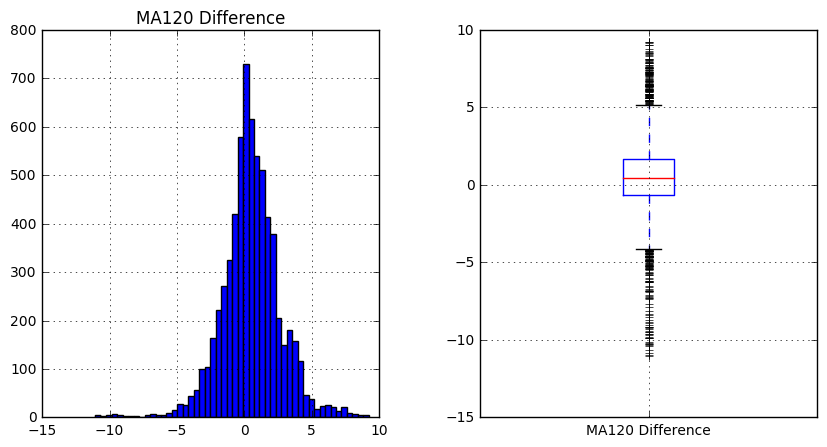

In [16]:
show_hist_box(msft_data, 'MA120 Difference')
print 'p-value (H0: MA120 difference is normally distributed)', normaltest(msft_data['MA120 Difference']).pvalue

Conclusions:

The close price vary significantly over time and exhibit a plateau-shaped histogram making it difficult to define what an outlier is.

First and second close price derivatives exhibit mound shaped distributions but they are not normal. We could use the Tukey method: ($value < Q1 - 1.5*IQR$ or $value > Q3 + 1.5*IQR$) to detect outliers.   

We could also try to apply transformations (log, sqrt etc.) but maybe better approach is to analyze multidimensional data.

In [17]:
def is_outlier(value, p25, p75):
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return value <= lower or value >= upper

def find_outliers(values):
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    return np.array([is_outlier(value, q1, q3) for value in values])

In [18]:
def show_outliers(df, data_column, outliers_mask, figsize=(12, 6), title = None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    df[data_column].plot(title = title, ax = ax)
    df[outliers_mask][data_column].plot(linestyle = '', marker = 'o', color = 'r', markersize = 7, ax = ax)  
    return ax

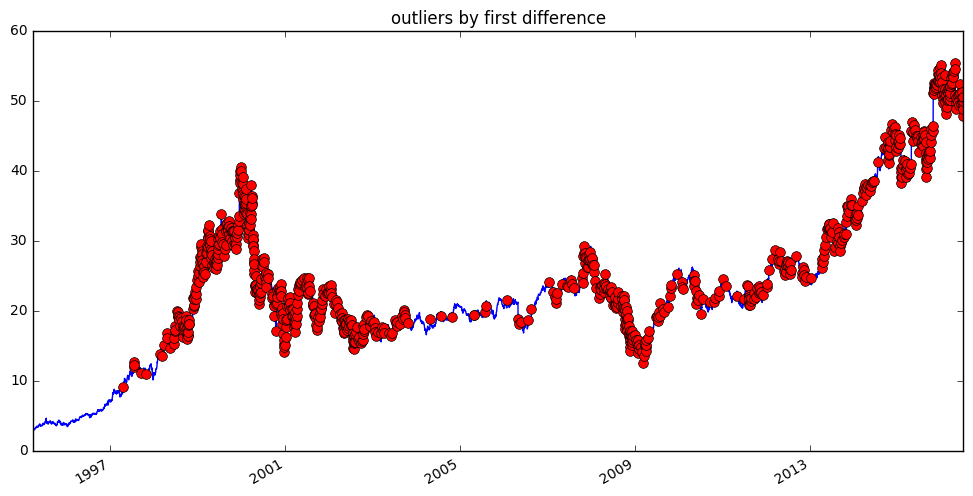

In [19]:
outliers_mask =  find_outliers(msft_data['First Difference'].as_matrix())
show_outliers(msft_data, 'Adj Close', outliers_mask, title = 'outliers by first difference')

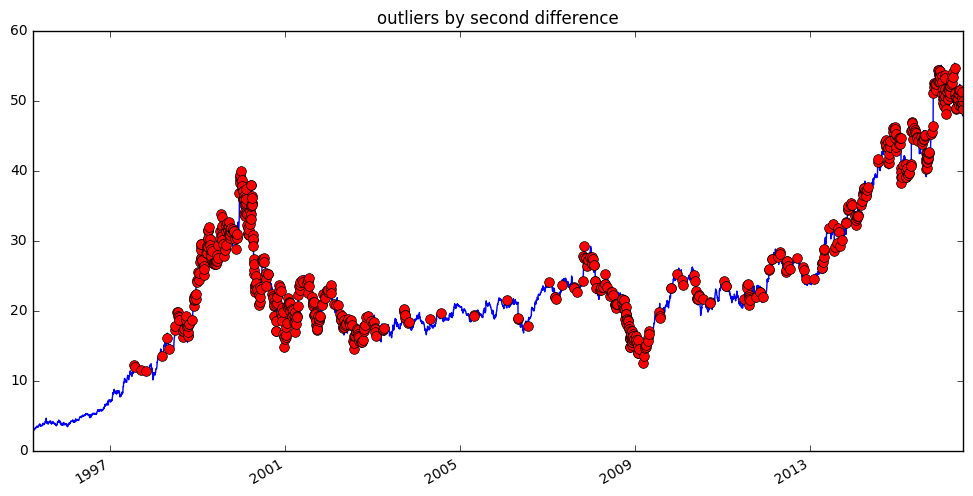

In [20]:
outliers_mask =  find_outliers(msft_data['Second Difference'].as_matrix())
show_outliers(msft_data, 'Adj Close', outliers_mask, title = 'outliers by second difference')

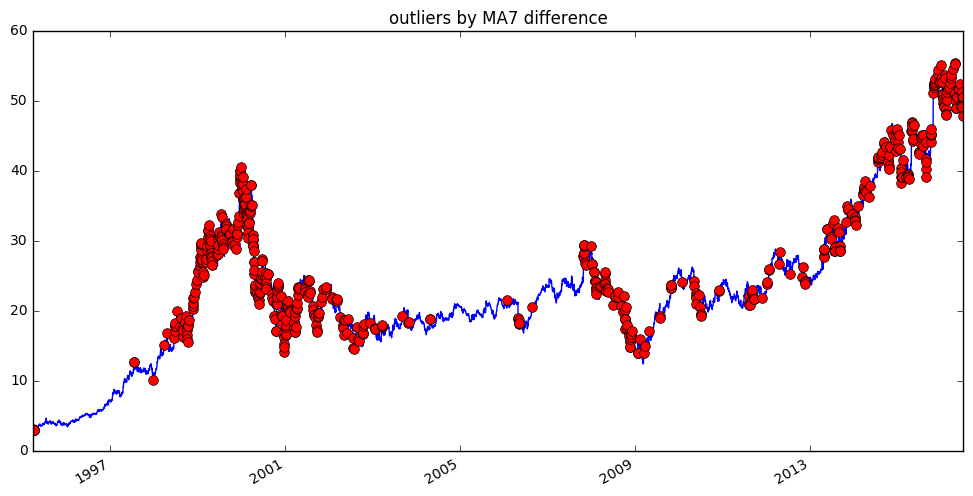

In [21]:
outliers_mask =  find_outliers(msft_data['MA7 Difference'].as_matrix())
show_outliers(msft_data, 'Adj Close', outliers_mask, title = 'outliers by MA7 difference')

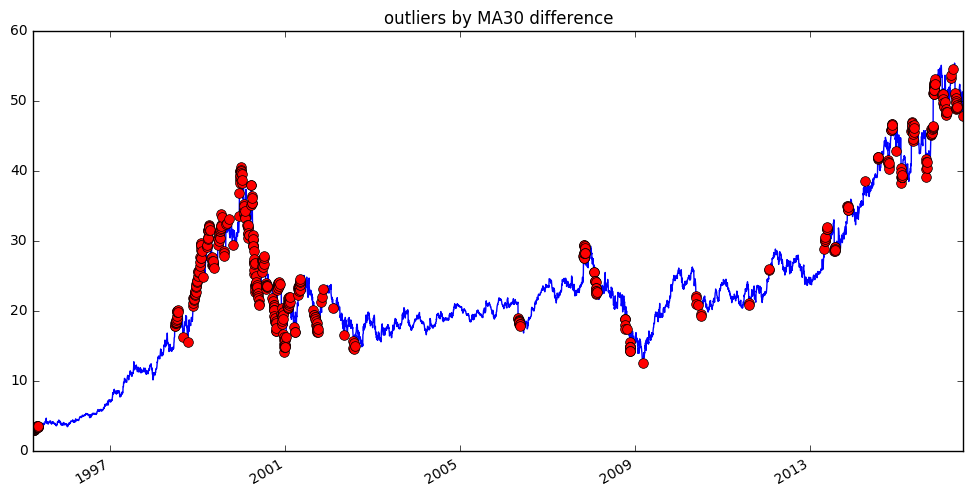

In [22]:
outliers_mask =  find_outliers(msft_data['MA30 Difference'].as_matrix())
show_outliers(msft_data, 'Adj Close', outliers_mask, title = 'outliers by MA30 difference')

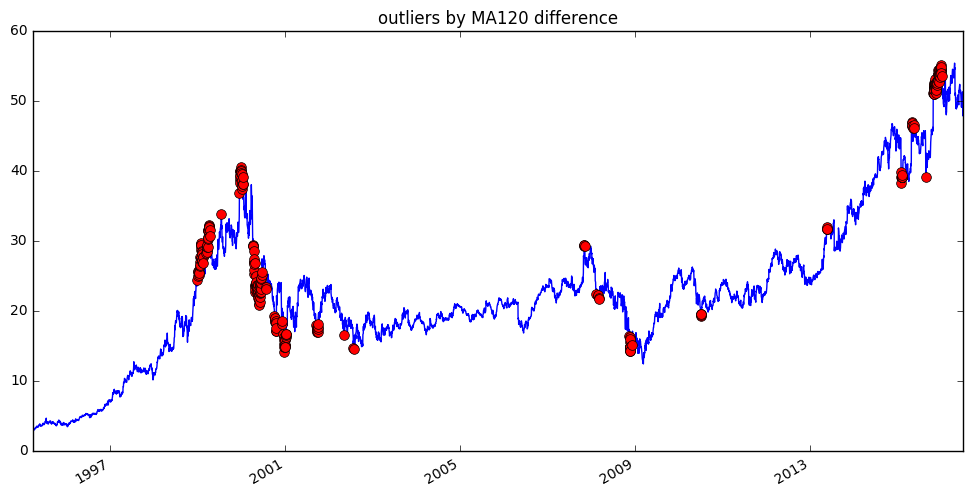

In [23]:
outliers_mask =  find_outliers(msft_data['MA120 Difference'].as_matrix())
show_outliers(msft_data, 'Adj Close', outliers_mask, title = 'outliers by MA120 difference')

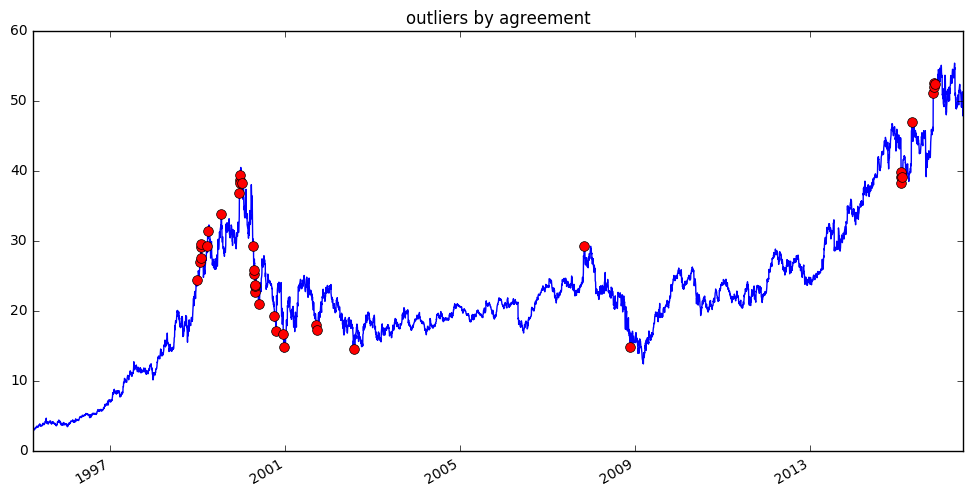

In [24]:
# any agree
outliers_mask =  find_outliers(msft_data['First Difference'].as_matrix())
outliers_mask = outliers_mask & find_outliers(msft_data['Second Difference'].as_matrix())
outliers_mask = outliers_mask & find_outliers(msft_data['MA7 Difference'].as_matrix())
outliers_mask = outliers_mask & find_outliers(msft_data['MA30 Difference'].as_matrix())
outliers_mask = outliers_mask & find_outliers(msft_data['MA120 Difference'].as_matrix())
show_outliers(msft_data, 'Adj Close', outliers_mask, title = 'outliers by agreement')

It is a very naive approach but might be useful. We could use it to detect sharp changes in the price where martingale-based approach will not work. Those changes might still be anomalies!

### Anomaly Detection by Testing Exchangeability

In [25]:
def knn_distance(X, k = 2):
    return np.sum(np.sort(np.abs(X[ : -1 ] - X[-1]))[ : k])

In [26]:
def calculate_pvalue(A):
    return (float(np.sum(A > A[-1])) + np.random.uniform()* float(np.sum(A == A[-1])))/float(A.size)

In [27]:
def calculate_martingale(P, e):
    return np.prod(e*np.power(P, e - 1.0))

In [28]:
def analyse_df(df, column, k, e):
    column_a = column + '_A'
    df[column_a] = df[column].expanding(min_periods = 1).apply(
        lambda x : knn_distance(x, k))
    column_p = column + '_P'
    df[column_p] = df[column_a].expanding(min_periods = 1).apply(
        lambda a : calculate_pvalue(a))
    column_m = column + '_M'
    df[column_m] = df[column_p].expanding(min_periods = 1).apply(
        lambda p : calculate_martingale(p, e))
    return df

In [29]:
def plot_analysis(df, column, figsize = (10, 6)):
    fig, ax1 = plt.subplots(figsize = figsize)
    ax1.plot(df[column], 'b-')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    ax2 = ax1.twinx()
    column_m = column + '_M'
    ax2.plot(df[column_m], 'r-')
    ax2.set_ylabel('M', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.show()

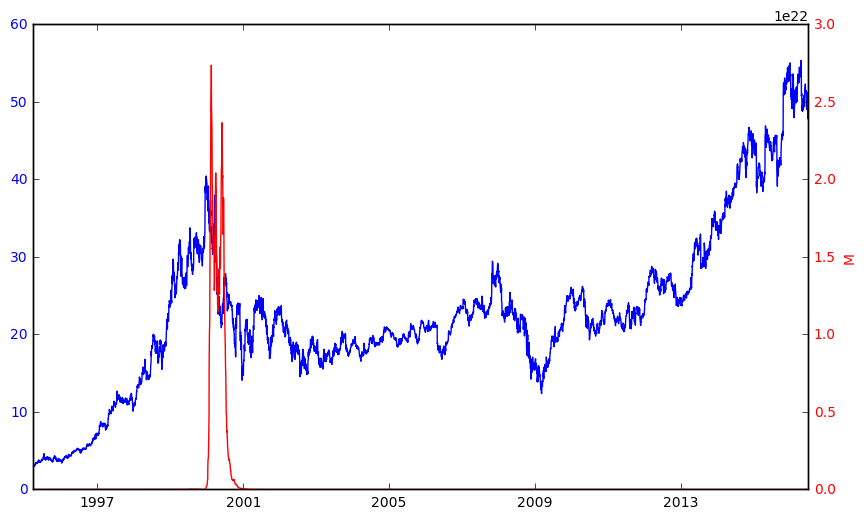

In [30]:
normal_df =  analyse_df(msft_data, 'Adj Close', 5, 0.9)
plot_analysis(normal_df, 'Adj Close')

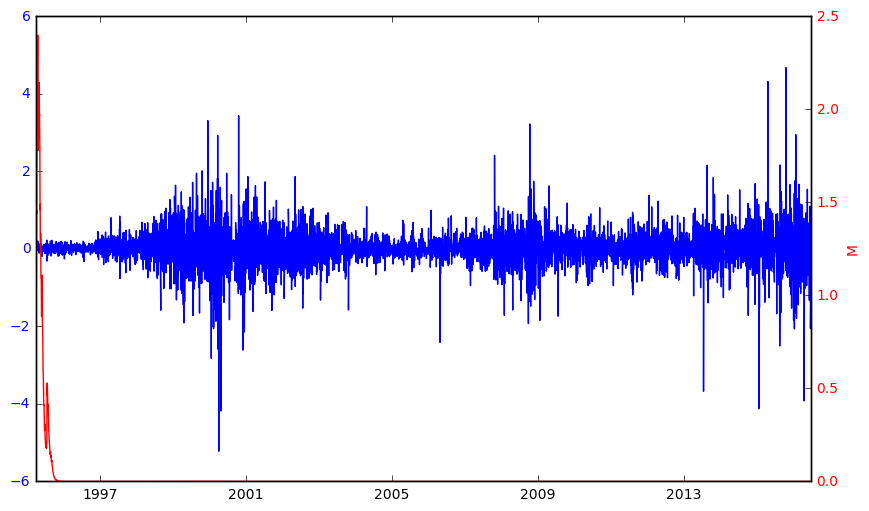

In [31]:
normal_df =  analyse_df(msft_data, 'First Difference', 5, 0.9)
plot_analysis(normal_df, 'First Difference')

This needs some work: investigation into what strangeness measures are appropriate.

### Other Outlier Detection Methods

Something that can handle mutidimensionsal data:

In [32]:
def show_boundaries(clf, X, threshold):
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), 500),
        np.linspace(X[:, 1].min(), X[:, 1].max(), 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    ax.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
    ax.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    ax.scatter(X[:, 0], X[:, 1], marker='^') 
    ax.set_xlim((X[:, 0].min(), X[:, 0].max()))
    ax.set_ylim((X[:, 1].min(), X[:, 1].max()))

In [33]:
X = msft_data[['Adj Close', 'First Difference']].as_matrix()
outliers_fraction = 0.05

In [34]:
clf = IsolationForest().fit(X)
scores = clf.decision_function(X)
threshold = sp.stats.scoreatpercentile(scores, 100 * outliers_fraction)

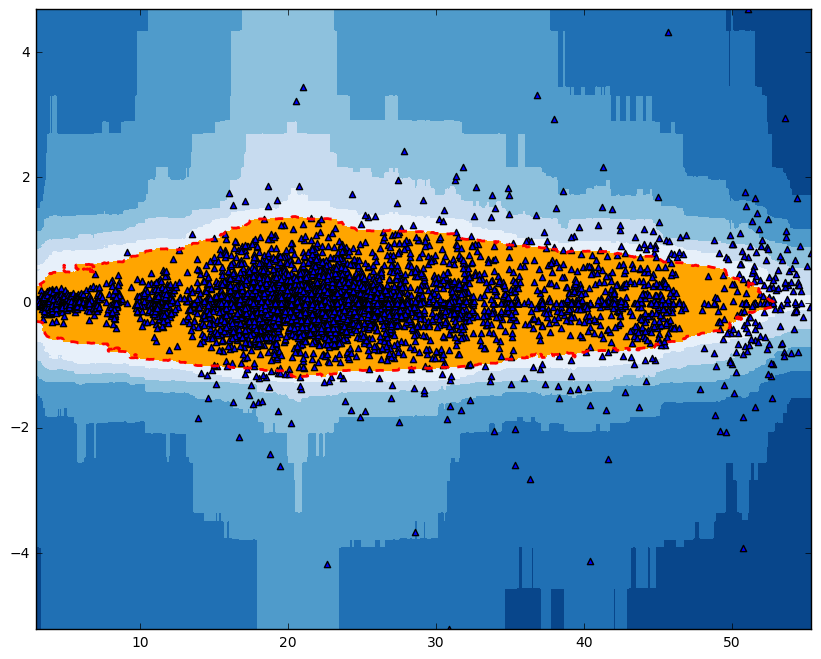

In [35]:
show_boundaries(clf, X, threshold)

In [36]:
clf = EllipticEnvelope().fit(X)
scores = clf.decision_function(X)
threshold = sp.stats.scoreatpercentile(scores, 100 * outliers_fraction)

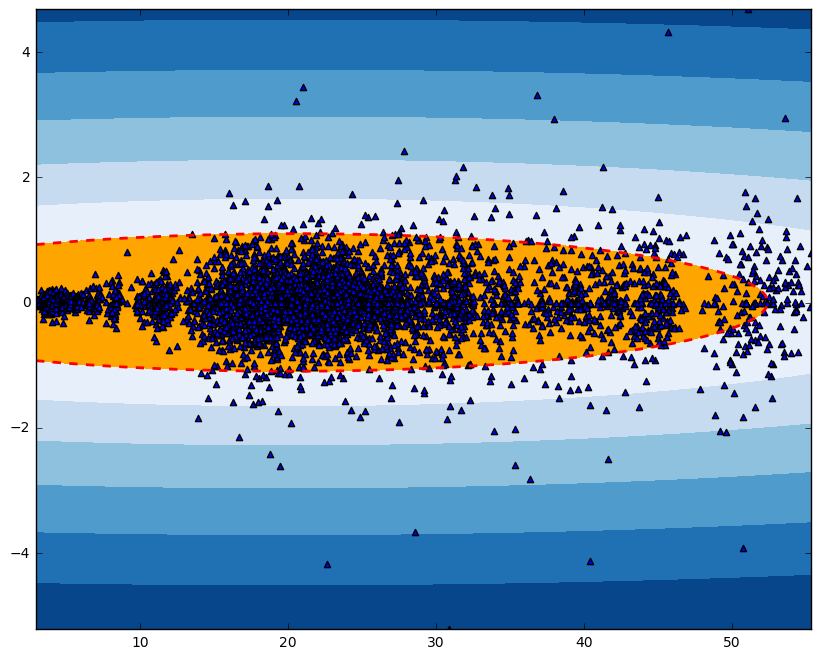

In [37]:
show_boundaries(clf, X, threshold)

In [38]:
clf = OneClassSVM(nu=0.261, gamma=0.05).fit(X)
scores = clf.decision_function(X)
threshold = sp.stats.scoreatpercentile(scores, 100 * outliers_fraction)

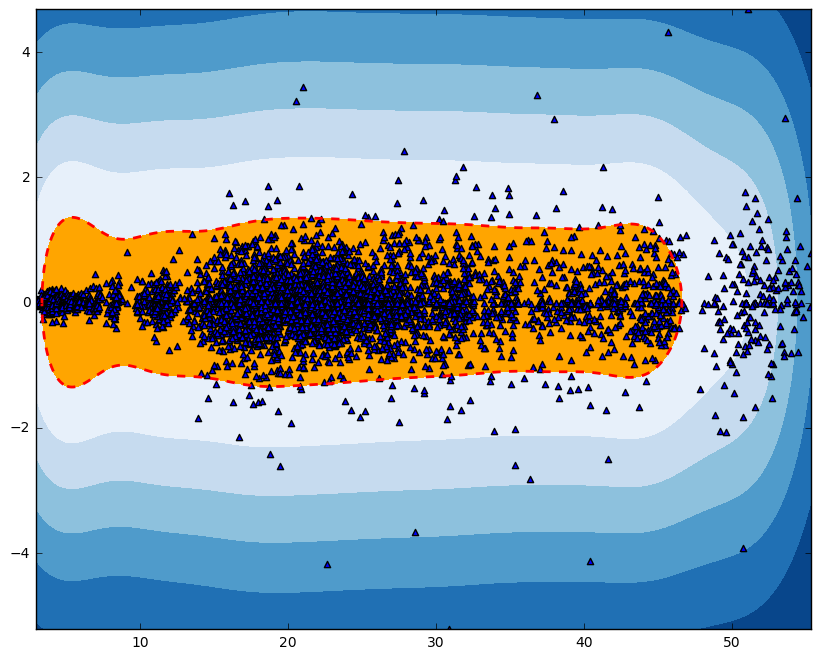

In [39]:
show_boundaries(clf, X, threshold)

### Clustering

If there are well-defined clusters, we should calculate strangeness accordingly.

In [40]:
ms = MeanShift(bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

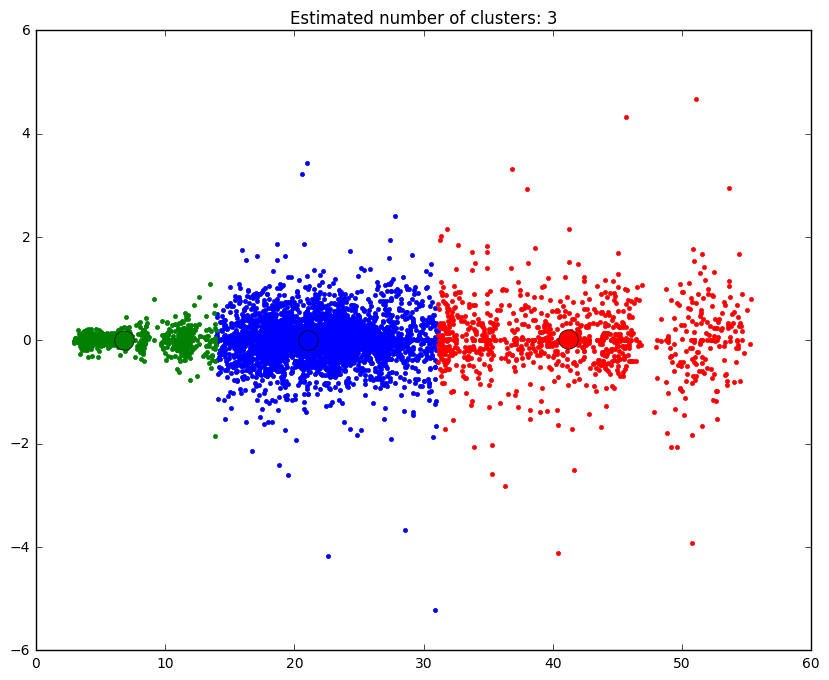

In [41]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], col + '.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

ax.set_title('Estimated number of clusters: %d' % n_clusters_)

In [42]:
X = msft_data[['Adj Close', 'SP500']].as_matrix()

In [43]:
clf = OneClassSVM(nu=0.261, gamma=0.05).fit(X)
scores = clf.decision_function(X)
threshold = sp.stats.scoreatpercentile(scores, 100 * outliers_fraction)

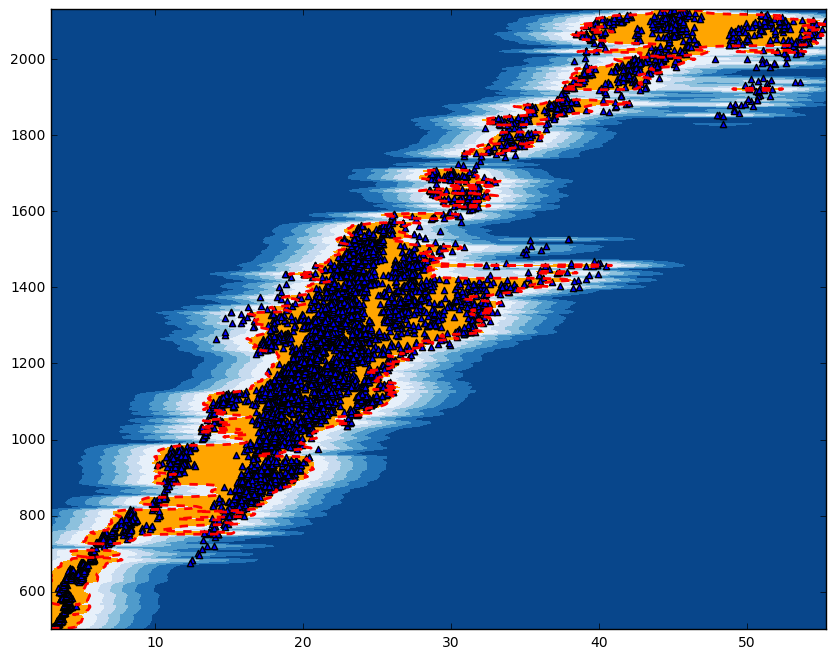

In [44]:
show_boundaries(clf, X, threshold)

In [45]:
ms = MeanShift(bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

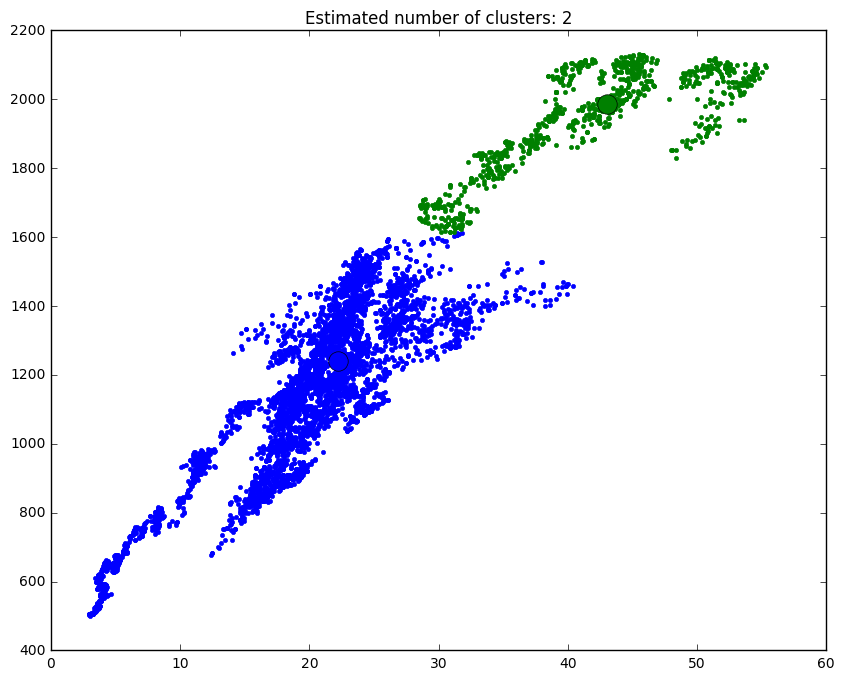

In [46]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], col + '.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

ax.set_title('Estimated number of clusters: %d' % n_clusters_)

In [47]:
print msft_data.columns[20]

424A


In [48]:
clf = OneClassSVM(nu=0.261, gamma=0.05).fit(X[ :-1, :])